In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin
import os
import scipy as scp
from scipy.linalg import expm
from sympy.physics.quantum.sho1d import RaisingOp, LoweringOp
from sympy.physics.quantum import qapply, represent

import scienceplots

plt.style.use(['science', 'notebook', 'nature'])

In [56]:
# number of vectors taken from the computational basis
d_unit = 20
dir_res = 'results'


# Tools


In [57]:
def n_avg(beta) :
    '''
    Returns the average number of particles at a given inverse temperature

    Parameters
    ----------
    beta : array
        inverse temperature

    Return
    ------
    n_avg : array
        average number of particles at T=1/beta

    '''
    return 1/(np.exp(beta) - 1)

n_avg(0.5)

1.5414940825367982

In [126]:
def save_results(sols, folder, subfolder, i) :
    '''
    Save the results of the optimization in a subfolder of folder

    Parameters
    ----------
    sols : dic
        results of the optimization
    folder : str
        location where output is written
    subfolder : str
        name of the subfolder
    i : int
        index of optimization
    '''
    subfolder = f'{folder}/output_{i}'
    os.makedirs(subfolder, exist_ok=True)

    np.savetxt(f'{subfolder}/history.txt', sols['history'])
    np.savetxt(f'{subfolder}/loss_rho_best.txt', sols['fopt'])
    np.savetxt(f'{subfolder}/lagr_best.txt', sols['lagr_best'])
    np.savetxt(f'{subfolder}/inverse_temperature.txt', sols['inv_temp'])
    np.savetxt(f'{subfolder}/rho_best.txt', np.atleast_1d(sols['rho_best'].toarray()))
        


def optimize(l, lagr_0, a, at, beta, dim_single_part, ansatz, exponent_ansatz, lindblad, folder, i, **args) :
    '''
    Minimize the loss l with respect to the lagrange multipliers, 
    and write all results in folder/output.data

    Parameters
    ----------
    l : function
        loss
    lagr_0 : array
        initial guess for the lagrange multipliers
    a : array
        annihilation operator
    at : array
        creation operator
    beta : array
        inverse temperature
    ansatz : function
        compute the ansatz for the density matrix given lagrand multipliers
    exponent_ansatz : function
        compute the exponent of the ansatz for the density matrix
    lindblad : function
        compute the lindblad operator
    folder : str
        location where output is written
    i : int
        index of optimization
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)

    Note
    ----
    fmin[0]     # xopt 
    fmin[1]     # fopt
    fmin[2]     # nb iteration
    fmin[3]     # funcalls
    fmin[4]     # warnflag
    fmin[5]     # solution at each iterations
    '''
    sols = {}
    solution = fmin(lambda x: l(x, ansatz, exponent_ansatz, a, at, lindblad, beta, **args), lagr_0, retall=True, full_output=True)
    sols['inv_temp'] = np.array([beta])
    sols['history'] = np.array(solution[5])
    sols['lagr_best'] = solution[0]
    sols['rho_best'] = ansatz(sols['lagr_best'], a, at, dim_single_part, **args)
    sols['fopt'] = np.array([solution[1]])

    save_results(sols, folder, f'output_{i}', i)

    return sols



In [74]:
def exp_mat(M) :
    '''
    Computes the matrix exponential exp(M)
    
    Parameters
    ----------
    M : csr_array
        matrix

    Return
    ------
    exp(M) : csr_array
    '''
    return scp.sparse.csr_array(expm(M.toarray()))
    

# Quantum Operators


In [60]:
def creation_annihilation(N) :
    '''
    Create $a$ and $a^\dag$ the single particle creation and annihilation operators
    in the (sparse) matrix form, in the computational basis {|n>}.

    Parameters
    ----------
    N : int
        number of excited states to use in the basis
    
    Return
    ------
    a : coo_array
        annihilation operator
    at : coo_array
        creation operator
    '''
    a = LoweringOp('a')
    ad = RaisingOp('a')

    a = scp.sparse.coo_array(represent(a, ndim=N, format="scipy.sparse"))
    ad = scp.sparse.coo_array(represent(ad, ndim=N, format="scipy.sparse"))

    return a, ad

a, ad = creation_annihilation(d_unit)

# Hamiltonians


In [81]:
def H_sho(a, at, dim_single_part, **args) :
    '''
    Computes the matrix form of the Hamiltonian of the Simple Harmonic Oscillator
    in the computational basis: 
    $ H = a^\dag a $

    Parameters
    ----------
    a : coo_array
        annihilation operator
    at : coo_array
        creation operator
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)  

    Return
    ------
    H : coo_array
        matrix form of Hamiltonian 
    '''
    extra_params = args 
    a, at = creation_annihilation(dim_single_part)
    H = scp.sparse.coo_array(at @ a)
    return H

np.diagonal(H_sho(a, ad, d_unit).toarray())

c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19.])

# Ansätze


Ansatz : $ \hat \rho = \frac{e^{- \lambda \hat a^\dagger \hat a}}{\text{Tr}(e^{- \lambda \hat a^\dagger \hat a})}$


In [87]:
def exponent_ansatz_sho(lagr, a, at, dim_single_part, **args) :
    '''
    Exponent of the ansatz for the density matrix given some parameters
    Ansatz : $ \hat \rho = \frac{e^{- \lambda \hat a^\dagger \hat a}}{\text{Tr}(e^{- \lambda \hat a^\dagger \hat a})}$

    Parameters
    ----------
    lagr : array
        Lagrange multipliers of (pseudo-)conserved quantities.
        They are the variational parameters
    a : coo_array
        annihilation operator
    at : coo_array
        creation operator
    dim_single_part : int
        number of excited states to use in the basis
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)
    
    Return
    ------
    exponent : cooarray

    Note
    ----
    Used to simplify the computation of entropy production
    '''
    return - lagr * H_sho(a, at, dim_single_part, **args)

def ansatz_sho(lagr, a, at, dim_single_part, **args) :
    '''
    Creates an ansatz for the density matrix given some parameters
    Ansatz : $ \hat \rho = \frac{e^{- \lambda \hat a^\dagger \hat a}}{\text{Tr}(e^{- \lambda \hat a^\dagger \hat a})}$

    Parameters
    ----------
    lagr : array
        Lagrange multipliers of (pseudo-)conserved quantities.
        They are the variational parameters
    a : coo_array
        annihilation operator
    at : coo_array
        creation operator
    dim_single_part : int
        number of excited states to use in the basis
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)
        
    Return
    ------
    rho : array
        density matrix (ansatz)
    '''
    U = exp_mat(- lagr * H_sho(a, at, dim_single_part, **args))
    rho = U / scp.sparse.csr_matrix.trace(U)
    return rho

exponent_ansatz_sho(0.7, a, ad, d_unit), ansatz_sho(0.7, a, ad, dim_single_part=d_unit)   

(<20x20 sparse array of type '<class 'numpy.float64'>'
 	with 19 stored elements in Compressed Sparse Row format>,
 <20x20 sparse array of type '<class 'numpy.float64'>'
 	with 20 stored elements in Compressed Sparse Row format>)

# Lindbladian


$ \mathcal{L} \hat \rho = - i\mkern1mu \left[\hat H, \hat \rho \right] + \gamma (\bar n + 1) \left( \hat a \hat \rho \hat a^\dag - \frac{1}{2} \left\{ \hat a^\dag \hat a, \hat \rho \right\} \right) + \gamma \bar n \left( \hat a^\dag \hat \rho \hat a - \frac{1}{2} \left\{ \hat a \hat a^\dag, \hat \rho \right\} \right)$


In [84]:
def lindblad(M, H, a, at, beta, **args) :
    '''
    Computes the lindbladian of a density matrix M given a Hamiltonian H

    Parameters
    ----------
    M : csr_array 
        density matrix
    H : coo_array
        Hamiltonian
    a : coo_array
        annihilation operator
    at : coo_array
        creation operator
    beta : float
        inversee temperature
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)

    Return
    ------
    L : float
        the lindbladian
    '''
    L0 = - 1j * (H @ M - M @ H)
    L1 = (n_avg(beta) + 1) * (a @ M @ at - 0.5 * (at @ a @ M + M @ at @ a))
    L2 = n_avg(beta) * (at @ M @ a - 0.5 * (a @ at @ M + M @ a @ at))
    return L0 + L1 + L2

rho = ansatz_sho(0.7, a, ad, dim_single_part=d_unit)
H = ansatz_sho(0.7, a, ad, dim_single_part=d_unit) 

lindblad(rho, H, a, ad, 0.5)

<20x20 sparse array of type '<class 'numpy.complex128'>'
	with 20 stored elements in Compressed Sparse Row format>

# Losses


In [102]:
def entropy_production(lagr, ansatz, exponent_ansatz, a, ad, lindblad, beta, **args) :
    '''
    Computes the entropy production of a density matrix given some parameters


    Parameters
    ----------
    lagr : array
        Lagrange multipliers of (pseudo-)conserved quantities.
        They are the variational parameters
    ansatz : function
        compute the ansatz for the density matrix given lagrange multipliers
    exponent_ansatz : function
        compute the exponent of the ansatz for the density matrix given lagrange multipliers
    a : coo_array
        annihilation operator
    ad : coo_array
        creation operator
    lindblad : function
        computes the lindbladian of a density matrix M given a Hamiltonian H
    beta : float
        inverse temperature
    **args : dic
        (optional) extra parameters used in the Hamiltonian (like
        frequencies, ratio parameters, ...)

    Return
    ------
    S_prod : float
        the entropy production
    '''
    ansats_M = ansatz(lagr, a, ad, dim_single_part=d_unit)
    exponent_ansatz_M = exponent_ansatz(lagr, a, ad, dim_single_part=d_unit)
    tot_dim = exponent_ansatz_M.shape[0]
    I = scp.sparse.eye(tot_dim)
    Z = scp.sparse.csr_matrix.trace(exp_mat(exponent_ansatz_M))

    lindbladian = lindblad(ansats_M, H, a, ad, beta, **args)
    S_prod = -scp.sparse.csr_matrix.trace((I + exponent_ansatz_M - np.log(Z) * I) @ lindbladian) 
    return np.abs(S_prod)

ans, exp_ans = exponent_ansatz_sho(0.7, a, ad, d_unit), ansatz_sho(0.7, a, ad, dim_single_part=d_unit) 
lindbladian = lindblad(ans, exp_ans, a, ad, 0.5) 
entropy_production(0.7, ansatz_sho, exponent_ansatz_sho, a, ad, lindblad, 0.5)

c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0.38853560268142395

# Case 7


In [111]:
case = 7
folder = f'{dir_res}/case_{case}'
os.makedirs(folder, exist_ok=True)

##### set-up


In [112]:
N = 20
lambda_0 = np.array([1])
a, at = creation_annihilation(N)
betas = np.linspace(1, 5, 3)        # true inverse temperature
H = H_sho(a, at, N)                 # Hamiltonian
ansatz = ansatz_sho
exponent_ansatz = exponent_ansatz_sho

c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


##### compute


In [127]:
for i,beta in enumerate(betas) :
    opt = optimize(entropy_production, lambda_0, a, at, beta, N, ansatz, exponent_ansatz, lindblad, folder, i)
    print(opt['lagr_best'])

c:\Users\antho\miniconda3\envs\perso\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
[1.]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 19
         Function evaluations: 38
[3.]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 21
         Function evaluations: 42
[5.]


##### Plot


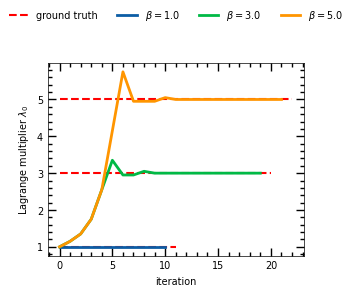

In [128]:
lagr_to_plot = [0]

for i,beta in enumerate(betas) :

    subfolder = f'{folder}/output_{i}'
    explored_solutions = np.loadtxt(f'{subfolder}/history.txt', unpack=True)

    for lagr in lagr_to_plot :
        plt.figure(lagr)
        if lagr == 0 :
            plt.hlines(beta, 0, len(explored_solutions), color='r', ls='--', lw=1.5, label='ground truth' if i==0 else "")
        plt.plot(explored_solutions, lw=2, label=rf'$\beta = {round(beta,2)}$')

for lagr in lagr_to_plot :
    plt.figure(lagr)   
    plt.xlabel("iteration")
    plt.ylabel(rf"Lagrange multiplier $\lambda_{lagr}$")
    plt.legend(loc='upper center', ncols=4, bbox_to_anchor=(0.5, 1.33))
    plt.savefig(f'figs/opti_case_{case}_lagr_{lagr}.pdf', bbox_inches='tight')


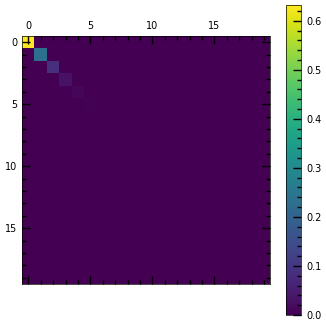

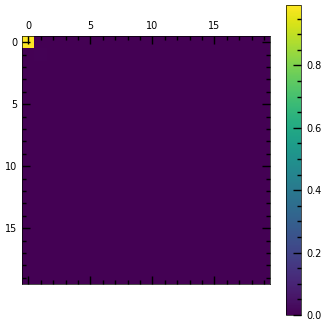

In [129]:
for i,beta in enumerate(betas) :
    subfolder = f'{folder}/output_{i}'
    estimated_rho = np.loadtxt(f'{subfolder}/rho_best.txt')

    plt.matshow(estimated_rho)
    plt.colorbar()
    plt.savefig(f'{subfolder}/rho_best.pdf', bbox_inches='tight')

    if i == 0 or i == len(betas) - 1 :
        plt.show()
    else :
        plt.close()